# Recommendation Systems

- **`Content Based Recommendation`**
  - Recommends items based on their characteristics and a user's preferences for those characteristics.
  - For example, a movie recommender might suggest films with similar genres or actors to ones a user has liked in the past.

- **`Collaborative Filtering`**
  - Recommends items based on the preferences of similar users.
  - It doesn't require knowledge of the items themselves, just information about user interactions.
  - For example, a music streaming service might recommend songs that other users with similar tastes have enjoyed.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
mlxtend  : 0.23.1
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
from typing import Generator


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.
    """
    result: list[str] = []
    # Starts with a capital letter and then lowercase letters
    pattern: re.Pattern[str] = re.compile(r"^[A-Z][a-z]+")
    prod_id: str = ""

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        line: str = line.strip()
        if len(line.split(",")) == 1 and not pattern.match(line):
            prod_id = line
        elif pattern.match(line):
            result.append(f"{prod_id}: {line}")

    return result


def parse_keys_values(filename: str) -> Generator[dict[str, str], None, None]:
    """
    Parse key-value pairs from a file.

    Parameters
    ----------
    filename : str
        The path to the file to be parsed.

    Yields
    ------
    dict[str, str]
        A dictionary containing key-value pairs parsed from the file.

    """
    entry: dict[str, str] = {}
    f = open(filename, "rb")

    # Iterate over all lines in the file.
    for l in f:
        l = l.strip()
        # The key/value pairs are separated by a colon.
        colonPos: int = l.find(b":")
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        key: str = l[:colonPos].decode("latin-1")
        value: str = l[colonPos + 2 :].decode("latin-1")
        entry[key] = value
    yield entry


def read_reviews(path: str, num: int = -1) -> pl.DataFrame:
    """
    Read reviews from a file and return them as a Polars DataFrame.

    Parameters
    ----------
    path : str
        The path to the file containing the reviews.
    num : int, optional
        The number of reviews to read. If -1, read all reviews. Default is -1.

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing the parsed reviews.

    """
    i: int = 0
    df: dict[int, dict[str, str]] = {}
    for d in parse_keys_values(path):
        df[i] = d
        i += 1
        if i == num:
            break
    result: pl.DataFrame = pl.DataFrame([x for x in df.values()])
    return result

In [4]:
fp: str = "../../data/prod_categories.parquet"

prod_categories: pl.DataFrame = pl.read_parquet(fp)
print(f"{prod_categories.shape = }")
prod_categories.head(3)

prod_categories.shape = (2437878, 2)


product_id,product_category
str,str
"""B00005AL88""","""Cookware, Cookware Sets, Kitchen & Dining, Home & Kitchen"""
"""B000002ERS""","""Music, World Music Music, Latin Music"""
"""B000PR126O""","""Jewelry, Charms"""


In [5]:
# Set verbosity level
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [6]:
# # Read the reviews from the data.
# reviews = read_reviews("../../../../../../../Downloads/Music.txt", 480_000)
# reviews.shape

In [7]:
fp: str = "../../data/Music_small.parquet"
music_df: pl.DataFrame = (
    pl.read_parquet(fp)
    .sample(fraction=1, shuffle=True, seed=123)
    .with_columns(
        score=pl.col("score").cast(pl.Float32),
        title=pl.col("title").str.to_lowercase(),
        summary=pl.col("summary").str.to_lowercase(),
        text=pl.col("text").str.to_lowercase(),
    )
)
print(f"{music_df.shape = }")
music_df.head(2)

music_df.shape = (480000, 10)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004R8TX""","""best jukebox album in the world ever""","""unknown""","""AGDF3UMMT64SJ""","""mitsos""","""1/1""",3.0,"""1104105600""","""a nice compilation...""","""...but somewhat limited.it could have included a wider time span, and more music genres. in my opin…"
"""B000001C5T""","""tomb of the mutilated""","""unknown""","""A2MA60UP0IBABN""","""Nekrophile ""730 wacko""""","""0/2""",4.0,"""1204675200""","""pretty solid-3.7 stars""","""and i'll have some of whatever the f@ck lunaqua is taking. seriously, you sound like a very brainwa…"


### Data Cleaning

In [8]:
music_df.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004R8TX""","""best jukebox album in the world ever""","""unknown""","""AGDF3UMMT64SJ""","""mitsos""","""1/1""",3.0,"""1104105600""","""a nice compilation...""","""...but somewhat limited.it could have included a wider time span, and more music genres. in my opin…"
"""B000001C5T""","""tomb of the mutilated""","""unknown""","""A2MA60UP0IBABN""","""Nekrophile ""730 wacko""""","""0/2""",4.0,"""1204675200""","""pretty solid-3.7 stars""","""and i'll have some of whatever the f@ck lunaqua is taking. seriously, you sound like a very brainwa…"
"""B000EBGFKO""","""roots blues & jazz""","""14.99""","""A15PTAF4AH3GGH""","""Gaylen Halbert""","""3/4""",5.0,"""1166400000""","""ike's opinion good enough for me""","""it was ike turner's ""opinion"" on the cd liner that convinced me to buy this album yesterday. best i…"
"""B00000ES5Y""","""idea""","""unknown""","""A3P867ODHBLJ3U""","""Harry Young""","""0/0""",5.0,"""1293148800""","""good before disco bee gees""","""i like this cd because i'm a fan of bee gees, and i enjoy their pre-disco stuff just as much as the…"
"""B00004R7NF""","""the sickness""","""unknown""","""A373AARR4HRI1X""","""M. Brandon Robbins ""literature and writing en...""","""3/4""",5.0,"""1094342400""","""a metal band with heart""","""allow me to climb up on my soap box and say that rock music is the last mainstream form of music th…"


In [9]:
# Check for unique product and userId entries
p_id: str = "B000058A81"
user_id: str = "A18C9SNLZWVBIE"
music_df.filter((pl.col("productId").eq(p_id) & pl.col("userId").eq(user_id)))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B000058A81""","""chrono cross: original soundtrack""","""unknown""","""A18C9SNLZWVBIE""","""A reader""","""1/1""",5.0,"""1096934400""","""first album i've bought since napster""","""we've come a long way since the days of ninetendo synthesized music! i say without exaggeration tha…"


In [10]:
# We want a:
# unique user-product pair.
# unique user-title pair.
# unique product-title pair.

print(f"[Before data cleaning]: {music_df.shape}")

# Remove duplicates
music_cleaned_df: pl.DataFrame = music_df.unique(subset=["userId", "productId"])
music_cleaned_df = music_cleaned_df.unique(subset=["userId", "title"])
# music_cleaned_df = music_cleaned_df.unique(subset=["productId", "title"])

print(f"[After data cleaning]: {music_cleaned_df.shape}")

[Before data cleaning]: (480000, 10)
[After data cleaning]: (369950, 10)


In [11]:
music_cleaned_df.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B000006ULR""","""calender girl / your number please""","""unknown""","""A2610PTZBUUDI9""","""""capncw""""","""9/9""",5.0,"""945475200""","""just pull your heartstrings right on out!""","""warning! do not listen to this cd alone! julie's voice, recorded here, in analog, at the height of …"
"""B000JK8OYU""","""love""","""13.99""","""A207J61G5C9PBE""","""Michael Grove ""Live Free""""","""0/0""",5.0,"""1168819200""","""love""","""this past summer my honey and i witnessed the cirque du soleil presentation of love, while in vegas…"
"""B000AL8LD2""","""torn hard dug deep""","""14.10""","""A1TUTCTFLKYTNY""","""john t. ""john t-bone""""","""0/0""",5.0,"""1122940800""","""intelligent lyrics, good melodies""","""my wife and i listened to ""torn hard dug deep"" a few evenings ago, and: we very much enjoyed the so…"
"""B000027A9I""","""e. 1999 eternal""","""21.14""","""A3J50HTL2MH532""","""Dizze Dahmer""","""0/0""",5.0,"""1021507200""","""a classik""","""i first bought this cd a couple months after it first came out. after listening to this cd i wuz ho…"
"""B000F8DTD2""","""we don't need to whisper (clean)""","""15.62""","""AFTMZS0VB5R2I""","""Kee ""-""""","""2/11""",1.0,"""1148342400""","""don't waste your money!""","""this album is almost as bad as courtney love's america's sweetheart. all of the songs sound the exa…"


In [12]:
# Check the unique userIDs
music_cleaned_df["userId"].value_counts(sort=True).head()

userId,count
str,u32
"""unknown""",14214
"""A9Q28YTLYREO7""",685
"""A2AIMXT9PLAM12""",346
"""A8IFUOL8S9BZC""",345
"""A2WQY1B8ZS7QRZ""",310


In [13]:
# Check the unique title
music_cleaned_df["title"].value_counts(sort=True).head(20)

title,count
str,u32
"""fallen""",1915
"""measure of a man""",1837
"""american idiot [vinyl]""",1691
"""hybrid theory""",1325
"""in the zone""",1158
"""come away with me""",1148
"""blink 182""",1138
"""the massacre [vinyl]""",1050
"""sgt. peppers lonely hearts club band""",1003


In [14]:
# Drop the unwanted userIDs
rem_str: str = "unknown"
rem_str_2: str = ""
print(f"[Before data cleaning]: {music_cleaned_df.shape}")
music_cleaned_df = (
    music_cleaned_df.filter(pl.col("userId").ne(rem_str))
    .filter(pl.col("title").ne(rem_str_2))
    .filter(pl.col("title").is_not_null())
)

print(f"[After data cleaning]: {music_cleaned_df.shape}")

[Before data cleaning]: (369950, 10)
[After data cleaning]: (355681, 10)


In [15]:
music_cleaned_df.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B000006ULR""","""calender girl / your number please""","""unknown""","""A2610PTZBUUDI9""","""""capncw""""","""9/9""",5.0,"""945475200""","""just pull your heartstrings right on out!""","""warning! do not listen to this cd alone! julie's voice, recorded here, in analog, at the height of …"
"""B000JK8OYU""","""love""","""13.99""","""A207J61G5C9PBE""","""Michael Grove ""Live Free""""","""0/0""",5.0,"""1168819200""","""love""","""this past summer my honey and i witnessed the cirque du soleil presentation of love, while in vegas…"
"""B000AL8LD2""","""torn hard dug deep""","""14.10""","""A1TUTCTFLKYTNY""","""john t. ""john t-bone""""","""0/0""",5.0,"""1122940800""","""intelligent lyrics, good melodies""","""my wife and i listened to ""torn hard dug deep"" a few evenings ago, and: we very much enjoyed the so…"
"""B000027A9I""","""e. 1999 eternal""","""21.14""","""A3J50HTL2MH532""","""Dizze Dahmer""","""0/0""",5.0,"""1021507200""","""a classik""","""i first bought this cd a couple months after it first came out. after listening to this cd i wuz ho…"
"""B000F8DTD2""","""we don't need to whisper (clean)""","""15.62""","""AFTMZS0VB5R2I""","""Kee ""-""""","""2/11""",1.0,"""1148342400""","""don't waste your money!""","""this album is almost as bad as courtney love's america's sweetheart. all of the songs sound the exa…"


In [16]:
# Check the unique titles
# music_cleaned_df["title"].value_counts(sort=True).slice(20, 40)
titles: list[dict[str, int]] = (
    music_cleaned_df["title"].value_counts(sort=True).to_dicts()
)
titles = sorted(titles, key=lambda x: x["title"], reverse=True)
titles[980:1000]

[{'title': 'whvn', 'count': 13},
 {'title': 'whose muddy shoes', 'count': 5},
 {'title': 'whose honey are you', 'count': 2},
 {'title': 'whorn [vinyl]', 'count': 2},
 {'title': 'whorn', 'count': 2},
 {'title': "whoops now / what'll i do", 'count': 1},
 {'title': 'whoop up', 'count': 4},
 {'title': 'whomp that sucker (reis)', 'count': 5},
 {'title': 'whole lotta love (ltd gold)', 'count': 5},
 {'title': 'whodunit - live', 'count': 1},
 {'title': 'whodunit', 'count': 1},
 {'title': 'whodini - greatest hits', 'count': 26},
 {'title': 'whoa! [vinyl]', 'count': 2},
 {'title': 'whoa nelly', 'count': 285},
 {'title': "who's your new professor [vinyl]", 'count': 7},
 {'title': "who's your new professor", 'count': 7},
 {'title': "who's who?", 'count': 1},
 {'title': "who's to bless & who's to blame", 'count': 3},
 {'title': "who's the boss [vinyl]", 'count': 3},
 {'title': "who's making love... [vinyl]", 'count': 3}]

In [17]:
text: str = "zoo rave"
music_cleaned_df.filter(pl.col("title").str.to_lowercase().str.contains(text))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str


### Apply Levenshtein Distance

- Levenshtein Distance is a string metric used to measure the difference between two sequences.
- It calculates the `minimum number of single-character edits` (`insertions`, `deletions`, or `substitutions`) required to change one word into another.
- It provides a quantitative measure of how dissimilar two strings are, which can be very useful in recommendation systems, especially for handling `typos` or `slight variations` in text input.
- It's an effective way to find close matches even when there are small differences between strings.

In [18]:
def levenshtein_distance(s1: str, s2: str) -> int:
    """
    Calculate the Levenshtein distance between two strings.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    int
        The Levenshtein distance between s1 and s2.

    Example
    -------
    >>> levenshtein_distance("kitten", "sitting")
    3
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row: list[int] = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row: list[int] = [i + 1]
        for j, c2 in enumerate(s2):
            insertions: int = previous_row[j + 1] + 1
            deletions: int = current_row[j] + 1
            substitutions: int = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def compute_string_similarity(s1: str, s2: str) -> float:
    """
    Compute the similarity between two strings based on Levenshtein distance.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    float
        A similarity score between 0 and 1, where 1 indicates identical strings.
    """
    distance: int = levenshtein_distance(s1, s2)
    max_length: int = max(len(s1), len(s2))
    similarity: float = 1 - (distance / max_length)
    return round(similarity, 4)

In [19]:
s1, s2 = "friend", "fiend"
distance: int = levenshtein_distance(s1=s1, s2=s2)
print(f"{distance = }")

similarity: float = compute_string_similarity(s1=s1, s2=s2)
print(f"{similarity = }")

distance = 1
similarity = 0.8333


In [20]:
temp_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": [
            "spider man",
            "Spider-Man",
            "Spiderman",
            "Anikulapo",
            "Aniku la po",
        ],
        "ratings": [5, 5, 4, 3, 3],
    }
)
temp_df

title,ratings
str,i64
"""spider man""",5
"""Spider-Man""",5
"""Spiderman""",4
"""Anikulapo""",3
"""Aniku la po""",3


In [21]:
temp_df = temp_df.with_columns(title=pl.col("title").str.to_lowercase())
uniq_titles: list[str] = temp_df["title"].unique().to_list()
schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
similarity_df: pl.DataFrame = pl.DataFrame(schema=schema)
similarity_df

title_1,title_2,similarity
str,str,f32


In [22]:
# Calculate similarity

result: list[dict[str, Any]] = []
threshold: float = 0.8

for idx, title_ in enumerate(uniq_titles):
    for n_title_ in uniq_titles[idx + 1 :]:
        score: float = compute_string_similarity(title_, n_title_)
        if score >= threshold:
            result.append({"title_1": title_, "title_2": n_title_, "similarity": score})
d: pl.DataFrame = pl.DataFrame(result, schema=schema)
similarity_df = pl.concat([similarity_df, d]).sort(by="title_1", descending=False)
similarity_df

title_1,title_2,similarity
str,str,f32
"""aniku la po""","""anikulapo""",0.8182
"""spider-man""","""spider man""",0.9
"""spiderman""","""spider-man""",0.9
"""spiderman""","""spider man""",0.9


In [23]:
def compute_similarity_matrix(
    unique_titles: list[str], threshold: float = 0.8
) -> pl.DataFrame:
    """
    Compute similarity matrix for unique titles.

    Parameters
    ----------
    unique_titles : list[str]
        List of unique titles to compare.
    threshold : float, optional
        Similarity threshold for including pairs, by default 0.8.

    Returns
    -------
    pl.DataFrame
        DataFrame containing similarity scores for title pairs above the threshold.
    """
    schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
    result: list[dict[str, Any]] = []

    for idx, title_ in enumerate(unique_titles):
        for n_title_ in unique_titles[idx + 1 :]:
            score: float = compute_string_similarity(title_, n_title_)
            if score >= threshold:
                result.append(
                    {"title_1": title_, "title_2": n_title_, "similarity": score}
                )

    d: pl.DataFrame = pl.DataFrame(result, schema=schema)
    similarity_df: pl.DataFrame = pl.DataFrame(data=d, schema=schema).sort(
        by="title_1", descending=False
    )
    return similarity_df

In [24]:
def create_title_mapping(similarity_list: list[dict[str, str]]) -> dict[str, str]:
    """
    Create a mapping of variant titles to their canonical forms.

    Parameters
    ----------
    similarity_list : list[dict[str, str]]
        A list of dictionaries, where each dictionary contains
        'title_1' and 'title_2' keys with string values.

    Returns
    -------
    dict[str, str]
        A dictionary mapping variant titles to their canonical forms.

    Notes
    -----
    The canonical form is chosen as the shorter of the two titles.
    """
    mapping: dict[str, str] = {}

    for item in similarity_list:
        title_1: str = item["title_1"]
        title_2: str = item["title_2"]

        # Choose the shorter title as the canonical form
        if len(title_1) <= len(title_2):
            canonical: str = title_1
            variant: str = title_2
        else:
            canonical: str = title_2
            variant: str = title_1

        mapping[variant] = canonical

    return mapping


def replace_similar(title: str, mapping: dict[str, str]) -> str:
    return mapping.get(title, title)

In [25]:
similarity_df: pl.DataFrame = compute_similarity_matrix(
    unique_titles=uniq_titles, threshold=0.75
)
similarity_df

title_1,title_2,similarity
str,str,f32
"""aniku la po""","""anikulapo""",0.8182
"""spider-man""","""spider man""",0.9
"""spiderman""","""spider-man""",0.9
"""spiderman""","""spider man""",0.9


In [26]:
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

{'aniku la po': 'anikulapo',
 'spider man': 'spiderman',
 'spider-man': 'spiderman'}

In [27]:
# Apply the replacement to the DataFrame
temp_df = temp_df.with_columns(
    title=pl.col("title").map_elements(
        lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8
    )
)
temp_df

title,ratings
str,i64
"""spiderman""",5
"""spiderman""",5
"""spiderman""",4
"""anikulapo""",3
"""anikulapo""",3


#### Apply To the Data

In [28]:
# music_cleaned_df.write_parquet("music_data_vsm.parquet")

# Load similarities
similarity_df: pl.DataFrame = pl.read_csv(
    "../../data/similar_titles.csv",
    separator="\t",
)
print(f"{similarity_df.shape = }")
similarity_df.head()

similarity_df.shape = (1574, 4)


,title_1,title_2,distance
i64,str,str,f64
0,"""Letters From Home""","""Letter From Home""",0.941176
1,"""Chrono Trigger""","""Chono Trigger""",0.928571
2,"""Atlantic""","""Atlantis""",0.875
3,"""Imagination""","""Imaginacion""",0.909091
4,"""Rockin' In Rhythm""","""Rockin in Rhythm""",0.882353


In [29]:
# # Ignore patterns with numbers.
# # e.g. bad boys 2 vs bad boys 3
# similarity_df = similarity_df.filter(
#     (
#         ~(
#             pl.col("title_1").str.contains(
#                 r"\w{1,20}\s*\w{1,20}[\s\.\'\-\:#,]*\w{0,3}\d{1,2}"
#             )
#         )
#         & ~(
#             pl.col("title_2").str.contains(
#                 r"\w{1,20}\s*\w{1,20}[\s\.\'\-\:#,]*\w{0,3}\d{1,2}"
#             )
#         )
#         & (pl.col("similarity").lt(1))
#     )
# )
# print(f"{similarity_df.shape = }")
# similarity_df.describe()

In [30]:
similarity_df.head(10)

,title_1,title_2,distance
i64,str,str,f64
0,"""Letters From Home""","""Letter From Home""",0.941176
1,"""Chrono Trigger""","""Chono Trigger""",0.928571
2,"""Atlantic""","""Atlantis""",0.875
3,"""Imagination""","""Imaginacion""",0.909091
4,"""Rockin' In Rhythm""","""Rockin in Rhythm""",0.882353
5,"""Suns & Moons""","""Sun & Moon""",0.833333
6,"""Live At Carnegie Hall""","""Live at Carnegie Hall""",0.952381
7,"""Don't Look Back""","""Dont Look Back""",0.933333
8,"""Tango Tango""","""Mango Tango""",0.909091


In [31]:
# print("[INFO]: Creating title mapping")
# mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
# len(mapping)

In [32]:
# # Apply the replacement to the DataFrame
# print("[INFO]: Replacing similar titles...")
# music_cleaned_df = music_cleaned_df.with_columns(
#     title=pl.col("title")
#     .map_elements(lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8)
#     .str.to_lowercase()
# )
# music_cleaned_df.head()

In [33]:
# Apply the replacement to the DataFrame
print("[INFO]: Replacing similar titles...")
music_cleaned_df = music_cleaned_df.filter(
    ~(
        pl.col("title")
        .str.to_lowercase()
        .is_in(similarity_df["title_2"].str.to_lowercase())
    )
)
print(f"{music_cleaned_df.shape = }")
music_cleaned_df.head()

[INFO]: Replacing similar titles...
music_cleaned_df.shape = (346453, 10)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B000006ULR""","""calender girl / your number please""","""unknown""","""A2610PTZBUUDI9""","""""capncw""""","""9/9""",5.0,"""945475200""","""just pull your heartstrings right on out!""","""warning! do not listen to this cd alone! julie's voice, recorded here, in analog, at the height of …"
"""B000JK8OYU""","""love""","""13.99""","""A207J61G5C9PBE""","""Michael Grove ""Live Free""""","""0/0""",5.0,"""1168819200""","""love""","""this past summer my honey and i witnessed the cirque du soleil presentation of love, while in vegas…"
"""B000AL8LD2""","""torn hard dug deep""","""14.10""","""A1TUTCTFLKYTNY""","""john t. ""john t-bone""""","""0/0""",5.0,"""1122940800""","""intelligent lyrics, good melodies""","""my wife and i listened to ""torn hard dug deep"" a few evenings ago, and: we very much enjoyed the so…"
"""B000027A9I""","""e. 1999 eternal""","""21.14""","""A3J50HTL2MH532""","""Dizze Dahmer""","""0/0""",5.0,"""1021507200""","""a classik""","""i first bought this cd a couple months after it first came out. after listening to this cd i wuz ho…"
"""B000F8DTD2""","""we don't need to whisper (clean)""","""15.62""","""AFTMZS0VB5R2I""","""Kee ""-""""","""2/11""",1.0,"""1148342400""","""don't waste your money!""","""this album is almost as bad as courtney love's america's sweetheart. all of the songs sound the exa…"


In [34]:
merged_df: pl.DataFrame = music_cleaned_df.join(
    prod_categories, left_on="productId", right_on="product_id", how="left"
)
merged_df = (
    merged_df.filter(
        pl.col("product_category").str.to_lowercase().str.contains("music")
    )
    .with_columns(product_category=pl.col("product_category").str.to_lowercase())
    .filter(pl.col("title").is_not_null())
)
print(f"{merged_df.shape = }")

merged_df.head()

merged_df.shape = (346453, 11)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text,product_category
str,str,str,str,str,str,f32,str,str,str,str
"""B000006ULR""","""calender girl / your number please""","""unknown""","""A2610PTZBUUDI9""","""""capncw""""","""9/9""",5.0,"""945475200""","""just pull your heartstrings right on out!""","""warning! do not listen to this cd alone! julie's voice, recorded here, in analog, at the height of …","""music, jazz music, pop music, broadway & vocalists"""
"""B000JK8OYU""","""love""","""13.99""","""A207J61G5C9PBE""","""Michael Grove ""Live Free""""","""0/0""",5.0,"""1168819200""","""love""","""this past summer my honey and i witnessed the cirque du soleil presentation of love, while in vegas…","""music, rock music, classic rock"""
"""B000AL8LD2""","""torn hard dug deep""","""14.10""","""A1TUTCTFLKYTNY""","""john t. ""john t-bone""""","""0/0""",5.0,"""1122940800""","""intelligent lyrics, good melodies""","""my wife and i listened to ""torn hard dug deep"" a few evenings ago, and: we very much enjoyed the so…","""music, blues music, rock"""
"""B000027A9I""","""e. 1999 eternal""","""21.14""","""A3J50HTL2MH532""","""Dizze Dahmer""","""0/0""",5.0,"""1021507200""","""a classik""","""i first bought this cd a couple months after it first came out. after listening to this cd i wuz ho…","""music, rock music, r&b music, rap & hip-hop"""
"""B000F8DTD2""","""we don't need to whisper (clean)""","""15.62""","""AFTMZS0VB5R2I""","""Kee ""-""""","""2/11""",1.0,"""1148342400""","""don't waste your money!""","""this album is almost as bad as courtney love's america's sweetheart. all of the songs sound the exa…","""music, rock music, alternative rock music, pop"""


In [35]:
# Unique products
merged_df["productId"].n_unique()

41328

In [36]:
pat: str = r"(,|\|)"
categories_str: str = " | ".join(merged_df["product_category"].to_list())
pattern: re.Pattern[str | Any] = re.compile(pat)
categories_list: list[str] = [
    x.strip() for x in pattern.split(categories_str) if x.strip() not in [",", "|"]
]
categories_df: pl.DataFrame = pl.DataFrame(
    list(set(categories_list)), schema={"category": pl.Utf8}
)

categories_df.head()

category
str
"""soundtracks new age"""
"""rock"""
"""gospel movies & tv"""
"""movies"""
"""hardware music"""


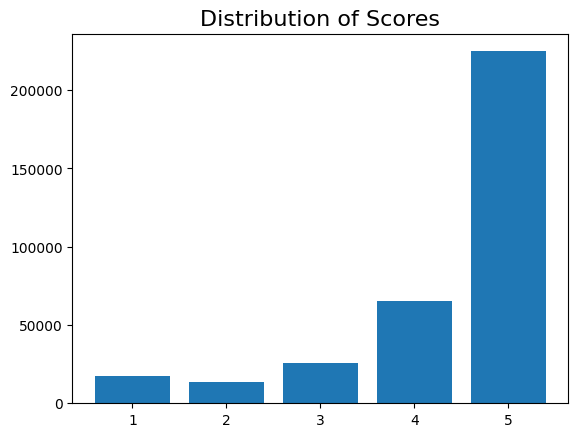

In [37]:
scores_df: pl.DataFrame = merged_df["score"].value_counts(sort=False)

plt.bar(scores_df["score"], scores_df["count"])
plt.title("Distribution of Scores", fontsize=16)
plt.show()

In [38]:
ratings_df: pl.DataFrame = merged_df.group_by("productId").agg(
    (
        pl.col("score").len().alias("count"),
        pl.col("score").mean().round(2).alias("avg_score"),
    )
)

ratings_df.head()

productId,count,avg_score
str,u32,f32
"""B000FSMGPE""",4,4.75
"""B000001C3O""",7,4.43
"""B00002DFQT""",1,5.0
"""B0000047GL""",9,4.89
"""B000024MQ4""",1,5.0


In [39]:
ratings_df.describe()

statistic,productId,count,avg_score
str,str,f64,f64
"""count""","""41328""",41328.0,41328.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,8.383009,4.406987
"""std""",null,36.548035,0.769615
"""min""","""0005123909""",1.0,1.0
"""25%""",null,1.0,4.0
"""50%""",null,2.0,4.67
"""75%""",null,5.0,5.0
"""max""","""B0033AGPGM""",1836.0,5.0


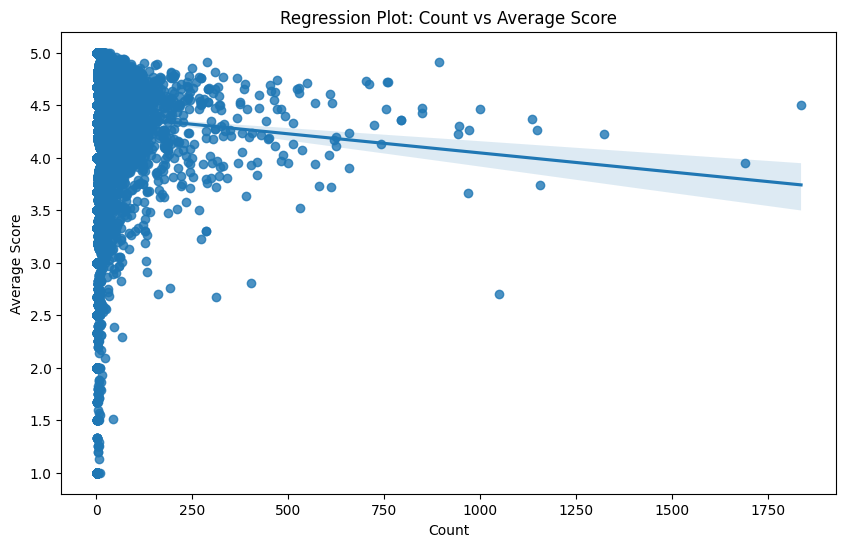

In [40]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.regplot(x="count", y="avg_score", data=ratings_df.to_pandas())
plt.title("Regression Plot: Count vs Average Score")
plt.xlabel("Count")
plt.ylabel("Average Score")
plt.show()

#### Comment:

- The correlation between the number of ratings and the ratings is negative.

In [41]:
uniq_titles_df: pl.DataFrame = merged_df.select(
    ["productId", "title", "product_category"]
).unique("title")
uniq_titles_df.shape

(37853, 3)

#### Create Metadata

- Metadata: product_category + summary + title

In [42]:
uniq_titles_df.head(2)

productId,title,product_category
str,str,str
"""B00000APZD""","""tension at the seams""","""music, hard rock & metal"""
"""B00005KBJR""","""shchedrin: carmen suite / concertos for orchestra nos. 1- naughty limericks, & 2- the chimes""","""music, classical"""


In [43]:
product_tags_df: pl.DataFrame = merged_df.group_by("productId").agg(
    pl.col("summary").map_elements(lambda x: " ".join(x))
)
product_tags_df.head()

productId,summary
str,str
"""B00006YX73""","""an outstanding bargain two-fer in this music"""
"""B00005KBBB""","""not just another greatest hits &quot;time's makin' changes&quot; is better... rock on.... a great a…"
"""B0000004Z6""","""pretty good set much love and respect still in the game, if not as strongly as before"""
"""B00000DCR6""","""beautiful voice, beautiful heart, beautiful music"""
"""B000FTKQLY""","""highest recommendation: cross-centered, god-glorifying album worship music at it's best god-exaltin…"


In [44]:
products_df: pl.DataFrame = uniq_titles_df.join(
    product_tags_df, on="productId", how="left"
)
products_df = (
    products_df.with_columns(
        product_category=pl.col("product_category")
        .str.replace_all("(music[\s,]?|[,])", "")
        .str.strip()
        .str.replace_all(r"\s{2,5}", " | ")
    )
    .with_columns(genres=pl.col("product_category").str.replace_all(r"\|", " "))
    .with_columns(
        metadata=pl.concat_list(
            pl.col("summary"), pl.col("genres"), pl.col("title")
        ).map_elements(lambda x: " ".join(x)),
    )
)

products_df.head()

productId,title,product_category,summary,genres,metadata
str,str,str,str,str,str
"""B00000APZD""","""tension at the seams""","""hard rock & metal""","""solid funk thrash album""","""hard rock & metal""","""solid funk thrash album hard rock & metal tension at the seams"""
"""B00005KBJR""","""shchedrin: carmen suite / concertos for orchestra nos. 1- naughty limericks, & 2- the chimes""","""classical""","""why is carmen so polite? not great music, but a lot of fun new twist on an old favorite, with delig…","""classical""","""why is carmen so polite? not great music, but a lot of fun new twist on an old favorite, with delig…"
"""B00004TVH5""","""flamenco""","""world | pop | latin""","""unexciting & pointless""","""world pop latin""","""unexciting & pointless world pop latin flamenco"""
"""B00002NDBC""","""complete studio recordings""","""alternative rock | classic rock | hard rock & metal | pop | rock""","""re-mastering the masters it doesn't get much better than this. great but not perfect ldoggs review …","""alternative rock classic rock hard rock & metal pop rock""","""re-mastering the masters it doesn't get much better than this. great but not perfect ldoggs review …"
"""B000EQ479A""","""robert gordon & chris spedding - rockin' the paradiso (2006)""","""pop tv movies & tv | rock""","""its a pal disc, i believe just to confuse the issue... mixed review great performance don't buy thi…","""pop tv movies & tv rock""","""its a pal disc, i believe just to confuse the issue... mixed review great performance don't buy thi…"


In [45]:
print(f"{products_df.shape = }")
products_df.select(["title", "metadata"]).head()

products_df.shape = (37853, 6)


title,metadata
str,str
"""tension at the seams""","""solid funk thrash album hard rock & metal tension at the seams"""
"""shchedrin: carmen suite / concertos for orchestra nos. 1- naughty limericks, & 2- the chimes""","""why is carmen so polite? not great music, but a lot of fun new twist on an old favorite, with delig…"
"""flamenco""","""unexciting & pointless world pop latin flamenco"""
"""complete studio recordings""","""re-mastering the masters it doesn't get much better than this. great but not perfect ldoggs review …"
"""robert gordon & chris spedding - rockin' the paradiso (2006)""","""its a pal disc, i believe just to confuse the issue... mixed review great performance don't buy thi…"


In [46]:
sp: str = "../../data/cleaned_products_data.parquet"
products_df.write_parquet(sp, use_pyarrow=True)

<br><hr>

### Content Based Recommender System

- Recommends items based on their characteristics and a user's preferences for those characteristics.
- Convert the text into vectors using TF-IDF.
- Reduce the dimensions using SVD.

In [47]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline


n_components: int = 200
seed: int = 123
pipe: Pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2)),
        ("svd", TruncatedSVD(n_components=n_components, random_state=seed)),
    ]
)
pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')),
                ('svd', TruncatedSVD(n_components=200, random_state=123))])

In [48]:
latent_vectors = pipe.fit_transform(products_df["metadata"].to_numpy())
latent_vectors.shape

(37853, 200)

In [49]:
def plot_cumulative_variance(estimator: TruncatedSVD) -> None:
    """
    Plot the cumulative variance percentage for a TruncatedSVD estimator.

    Parameters
    ----------
    estimator : TruncatedSVD
        The fitted TruncatedSVD estimator.

    Returns
    -------
    None
        This function doesn't return anything, it displays a plot.

    Notes
    -----
    The plot shows the cumulative explained variance ratio as a function
    of the number of components.
    """
    # Plot the cumulative variance percentage.
    explained: np.ndarray = (
        estimator.explained_variance_ratio_.cumsum()
    )  # shape: (n_components,)

    plt.figure(figsize=(6, 6))
    plt.plot(explained, ".-", ms=6, color="b")
    plt.xlabel("Num of components", fontsize=14)
    plt.ylabel("Cumulative variance percentage", fontsize=12)
    plt.title("Cumulative variance percentage", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

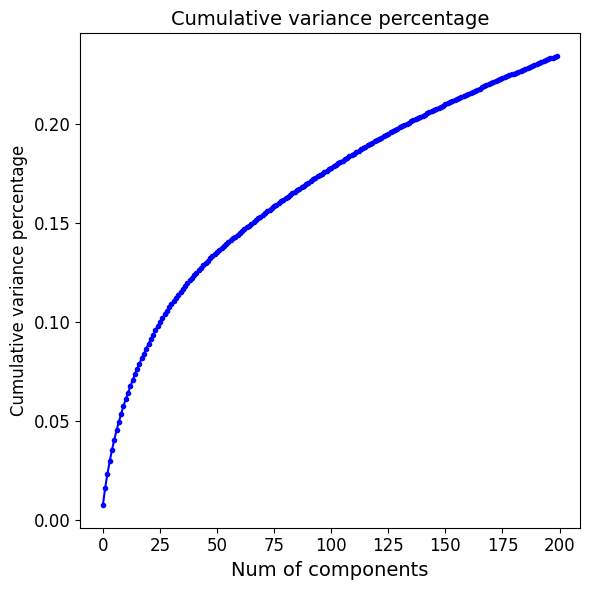

In [50]:
plot_cumulative_variance(estimator=pipe.named_steps.get("svd"))

In [51]:
# latent_df: pd.DataFrame = pd.DataFrame(latent_vectors, index=products_df["title"])
title_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": products_df["title"].str.to_lowercase(),
    }
)
latent_df: pl.DataFrame = pl.concat(
    [title_df, pl.DataFrame(latent_vectors)], how="horizontal"
)
latent_df.head()

title,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""tension at the seams""",0.166933,0.118796,-0.023697,0.051979,-0.005149,-0.020899,-0.073094,-0.116193,0.158994,-0.10349,0.05305,0.024557,-0.014935,-0.014793,0.001392,-0.035366,-0.015223,0.029133,-0.031614,-0.079397,0.00196,0.044737,-0.014251,-0.015763,0.04475,0.030144,0.003223,-0.003437,0.029071,0.013534,0.001867,0.021119,-0.011432,-0.00117,-0.010452,0.014173,-0.013651,0.032482,0.008551,-0.017678,0.030756,0.024465,0.023296,-0.007671,0.012697,0.000526,0.006719,-0.018925,0.000413,0.016035,-0.023171,0.021018,0.017101,-0.073626,0.00744,0.00388,0.039954,0.054397,0.020396,-0.012359,-0.004208,0.100574,-0.047016,0.024598,-0.083361,-0.109867,-0.007938,-0.018736,0.134568,0.135786,-0.014107,0.028078,0.044586,-0.003189,0.023715,0.032947,-0.031794,-0.034678,-0.039958,0.000857,-0.007167,-0.02908,0.000022,-0.01864,-0.014186,0.012454,-0.021361,0.01496,0.017046,0.005136,-0.006621,-0.01238,-0.015801,-0.013959,0.003464,0.021495,-0.020885,-0.011599,0.008354,-0.005257,0.019438,-0.035426,-0.034817,-0.010282,0.001218,-0.017688,-0.00244,0.001431,-0.03209,0.011316,0.008784,0.013361,0.024969,-0.017105,-0.04

In [52]:
latent_df["title"].sample(n=8, seed=seed)

title
str
"""david pascucci sings previn & previn"""
"""snow ep"""
"""confessin blues"""
"""just in time"""
"""bob and ray on a platter"""
"""crazy jane"""
"""i can stand a little rain"""
"""fruits basket single vocal album [audio cd]"""


In [53]:
import polars.selectors as cs


# Ignore the `title` column
latent_df.select(cs.float()).head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.166933,0.118796,-0.023697,0.051979,-0.005149,-0.020899,-0.073094,-0.116193,0.158994,-0.10349,0.05305,0.024557,-0.014935,-0.014793,0.001392,-0.035366,-0.015223,0.029133,-0.031614,-0.079397,0.00196,0.044737,-0.014251,-0.015763,0.04475,0.030144,0.003223,-0.003437,0.029071,0.013534,0.001867,0.021119,-0.011432,-0.00117,-0.010452,0.014173,-0.013651,0.032482,0.008551,-0.017678,0.030756,0.024465,0.023296,-0.007671,0.012697,0.000526,0.006719,-0.018925,0.000413,0.016035,-0.023171,0.021018,0.017101,-0.073626,0.00744,0.00388,0.039954,0.054397,0.020396,-0.012359,-0.004208,0.100574,-0.047016,0.024598,-0.083361,-0.109867,-0.007938,-0.018736,0.134568,0.135786,-0.014107,0.028078,0.044586,-0.003189,0.023715,0.032947,-0.031794,-0.034678,-0.039958,0.000857,-0.007167,-0.02908,0.000022,-0.01864,-0.014186,0.012454,-0.021361,0.01496,0.017046,0.005136,-0.006621,-0.01238,-0.015801,-0.013959,0.003464,0.021495,-0.020885,-0.011599,0.008354,-0.005257,0.019438,-0.035426,-0.034817,-0.010282,0.001218,-0.017688,-0.00244,0.001431,-0.03209,0.011316,0.008784,0.013361,0.024969,-0.017105,-0.044902,0.014547,-0.01902,0.058934,0.019

In [54]:
movie_title: str = "led zeppelin [vinyl]"
all_movie_vectors: np.ndarray = latent_df.select(cs.float())
movie_vector: np.ndarray = latent_df.filter(pl.col("title").eq(movie_title)).select(
    cs.float()
)
print(f"{movie_vector.shape = }")
print(f"{all_movie_vectors.shape = }")
# V @ m -> (234564, 200) @ (1, 200)
# V @ mT -> (234564, 200) @ (200, 1) -> (234564, 1)
cos_sim: np.ndarray = cosine_similarity(latent_df.select(cs.float()), movie_vector)
print(f"{cos_sim.shape = }")
similarity_measure_df: pl.DataFrame = pl.DataFrame(
    {"title": latent_df["title"], "similarity": cos_sim.flatten()}
).sort(by="similarity", descending=True)

similarity_measure_df.head()

movie_vector.shape = (1, 200)
all_movie_vectors.shape = (37853, 200)
cos_sim.shape = (37853, 1)


title,similarity
str,f64
"""led zeppelin [vinyl]""",1.0
"""iron maiden""",0.871745
"""2pacalypse now""",0.861683
"""definitely maybe""",0.858274
"""show no mercy""",0.854948


In [55]:
# Reccommend movies to users based on their preferences
N: int = 10
columns: list[str] = ["title", "product_category"]
recommend_df: pl.DataFrame = (
    similarity_measure_df.join(products_df.select(columns), on="title", how="left")
    .slice(0, N)
    .select(columns + ["similarity"])
)
recommend_df

title,product_category,similarity
str,str,f64
"""led zeppelin [vinyl]""","""classic rock | rock | hard rock & metal""",1.0
"""iron maiden""","""hard rock & metal | rock | alternative rock | pop""",0.871745
"""2pacalypse now""","""rap & hip-hop | pop""",0.861683
"""definitely maybe""","""alternative rock | rock | pop | hard rock & metal""",0.858274
"""show no mercy""","""hard rock & metal | pop | rock""",0.854948
"""in the heat of the night""","""classic rock | hard rock & metal | pop | rock""",0.830617
"""boy""","""miscellaneous | rock | alternative rock | soundtracks""",0.820953
"""motley crue - too fast for love (orig leathur lp)""","""hard rock & metal | rock | miscellaneous""",0.819688
"""ticket to ride""","""pop | rock""",0.818658


### Collaborative Filtering

- Collaborative filtering is a recommendation system technique that suggests items (like movies, products, or music) to users based on the preferences of similar users.
- The core idea is that if two users have similar tastes, they are likely to enjoy the same items.

#### Types of Collaborative Filtering

- There are primarily two main types of collaborative filtering:

  - `Memory-Based Collaborative Filtering`: This approach directly compares users or items to find similarities and make recommendations.
    - User-based: Finds users with similar tastes and recommends items that similar users liked.
    - Item-based: Finds items similar to those a user has liked and recommends those similar items.
  
  - `Model-Based Collaborative Filtering`: This approach builds a model from the data and uses it to make predictions.
    - Matrix Factorization: Represents users and items as vectors in a latent space and tries to predict missing ratings based on these vectors.
    - Clustering: Groups users or items into clusters based on similarity and makes recommendations based on cluster information.


<br>

#### Memory Based Colaborative Recommenders

- Filter out users with less than `X` number of ratings. i.e. select active users.
- Create a pivot table with items as index and ratings as columns. i.e. a matrix of ratings.
- Compute similarity between products using any metrics like cosine similarity, correlation, etc.
- Predict similar products for a given product.

In [56]:
percentile_range: np.ndarray = np.linspace(0.25, 0.99, 15)
music_cleaned_df["userId"].value_counts().describe(percentiles=percentile_range)

statistic,userId,count
str,str,f64
"""count""","""210679""",210679.0
"""null_count""","""0""",0.0
"""mean""",null,1.644459
"""std""",null,4.2154
"""min""","""A0001624UKLQG4OFIM8X""",1.0
"""25%""",null,1.0
"""30.2857%""",null,1.0
"""35.5714%""",null,1.0
"""40.8571%""",null,1.0


In [57]:
activity_threshold: int = 5
user_activity: list[str] = (
    music_cleaned_df["userId"]
    .value_counts(sort=True)
    .filter(pl.col("count").ge(activity_threshold))
)["userId"].to_list()

# Select active users
music_active_df: pl.DataFrame = music_cleaned_df.filter(
    pl.col("userId").is_in(user_activity)
)
print(f"{music_active_df.shape = }")
uniq_products_df: pl.DataFrame = music_active_df.unique(subset=["productId"])
print(f"{uniq_products_df.shape = }")

# Ratings for unique products
ratings_df: pl.DataFrame = music_active_df.filter(
    pl.col("productId").is_in(uniq_products_df["productId"])
).select(["userId", "productId", "score"])
print(f"{ratings_df.shape = }")

ratings_df.head()

music_active_df.shape = (91637, 10)
uniq_products_df.shape = (22262, 10)
ratings_df.shape = (91637, 3)


userId,productId,score
str,str,f32
"""A2WIJ0KSWC96M9""","""B00001R3G3""",3.0
"""A1XPTVJC8OMM3I""","""B000HBK10Q""",4.0
"""A2N71K3SDAS4PV""","""B00027JYY4""",2.0
"""AYXOKMQ8IJX7M""","""B00004WJHY""",5.0
"""ANDR5PCA6W83K""","""B00004WIL4""",5.0


In [58]:
print(f"{uniq_products_df.shape = }")
sp: str = "../../data/ratings_data.parquet"
ratings_df.select(["userId", "productId", "score"]).write_parquet(sp, use_pyarrow=True)

uniq_products_df.head()

uniq_products_df.shape = (22262, 10)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B000007Q76""","""bay area's greatest hits 1""","""unknown""","""A141XAG09QATRB""","""J. H Meeks ""west coast fan""""","""2/3""",5.0,"""1106179200""","""one of the all-time great compilations""","""first of all, one luv to the bay for putting down some of the best lyricists and musical talent to …"
"""B0000003W9""","""you'll never get to heaven""","""19.99""","""A2FWEZ0QS8N7A7""","""James Carragher""","""0/1""",3.0,"""1151366400""","""an honest folkie""","""he's good enough, sings some interesting stories, but nothing really sets him apart for me -- not h…"
"""B0000566V7""","""dead bees on a cake""","""unknown""","""A3DWUM6SN3N3NR""","""Author Brian Wallace (Mind Transmission, Inc.)""","""0/0""",5.0,"""926899200""","""destructive humans on a voluptuous orb - wake up""","""sinking your neurons into this cake is no mistake. from david's soul soothing vocals to musical tri…"
"""B000000408""","""lord god muzick""","""unknown""","""A14CWMXH8UTAFF""","""Sean M. Kelly""","""3/3""",4.0,"""969494400""","""nice""","""this cd from late 1991 shows perry's synthesizer based dub tracks in fine form. the tracks and his …"
"""B000002R71""","""rko live""","""unknown""","""A3QWNQ2WA7QZYJ""","""kireviewer""","""2/3""",3.0,"""1058745600""","""jazz trio plays the doors""","""this is a poor sounding live recording. there is no dynamic range. there is an echo. you can hear t…"


In [59]:
# All products vs all users
ratings_pivot_df: pl.DataFrame = ratings_df.pivot(
    index=["productId"], columns="userId", values="score"
).fill_null(0)

ratings_pivot_df.head(10)

productId,A2WIJ0KSWC96M9,A1XPTVJC8OMM3I,A2N71K3SDAS4PV,AYXOKMQ8IJX7M,ANDR5PCA6W83K,AZX0R6GC9106N,A2H2ACDVOPL0SS,A2QDVSE7HWRF04,A2ZZULCTI40V3A,AWQ0F396JD9U,A1OBPHRXHZF8P6,A1A4DEENGHK51T,A1ES0C91DRT7UT,A2BJ330CK94AB9,A32YO3MPI1X5AT,A2H4AWIOK1REMX,AU2MZBMCS5AJZ,A3R8PXSFGY9MC2,A2GVYHC1LULPIS,A14J4IMAJM6XBE,ATY9BK7MKHREX,AMDZA4HZ9FG86,A18A3H566K45D9,A3AXPB7OPZNOP4,A2Z83T6WL8EHHA,A179GX8E3M4G52,A8IFUOL8S9BZC,A3DIPWH4ESVLFJ,A1IANEBSMVGHS9,A36ONZ3LB9V7FO,A2JJSCIGPZDWHI,A16XRPF40679KG,A5TJL46NVFH47,A39NS429FYXAD1,A3M7RECGYLXOPA,A3AN9N2JXCKES7,A1DIFL0333QPEB,A1SWRPUO5LBNV1,AZ05JR3XQN9IP,A2P49WD75WHAG5,A1WHO8TXC8GJHA,A1RXU1ZIX8DAP7,ABVTOUQ06CHYN,A3AVJCB1ZD6ZY5,A1P05E2SWS6IY,A1F8KRXO5OMBZV,AFTN9ZLB22PSZ,A33HUURDJ4DVG3,A2Q5K1G3S8RLWX,A11JAR6S5WKB4Y,A1Y5V76H5A31QE,A2ZP8PIYL4EHTP,A3KE6JD05JVU59,A3RXNVTUSZ9MBW,ANSDZ09NJBNL,A3116ITCY40DC6,A2H0CGPPZ4X98Q,AHN34TYB15NWF,A1ANRKHR4QWXJU,A26P4DOSR9Q7KY,AO2AQRPPSTABB,A192KN1POM24YV,A30CJW1RNUHMN6,A13OD50LTDL2CQ,A3LALK8IUD9TDP,A3NL1KW56O3JR8,A3HTX1NOTTWERP,AKP40TIE5SVSQ,A1SDBHSES5S7LD,A4RG2QJGRRXUF,AF75JNZYJD4AE,A32U96RR2TCPA3,A2YAHYINX5KQRC,AQ4B80F0JSBNI,AHQHPSGH2YIT,AQLJ566RYMQ2M,AJK5WHV1GW941,AOYLVUVF5VZTU,A2ASIT0JYIGHTA,A2U49LUUY4IKQQ,AKGF27HN0OF19,A1LAS6RCNZL4CB,A1NXVGNVR1SBTW,A3HU0B9XUEVHIM,A1FML9FCUPV6TI,ABN1V96521UHH,A2U05WAY0ABGGI,A2DVFHG099GUGE,A1Q8TMHHMPQHO9,A1SCU0KWGGGBU4,A1P6NTDL1BKLDV,A2MMIZ653FBNPT,ASSCA9IS0GWF5,A1K66EHHQ4MYX7,A12AGEUWVTQMAE,A12992398DDK8X,ANEDLXQSCJT3O,A35XUI9HGMAJEX,AQP1VPK16SVWM,A8LVAO2H29WII,A3ON1MH6X9B2LD,A2TSHD7SWDGS58,A3SOV9HFM5H9T1,A1SD82ZAT3INZ2,A5A2QE6NECFR5,A3464G00K8ZYD1,A1KDBLH3HRPYKY,A1X4JO8EJ1U5BR,AEHVPBNCQ3VMX,A2UDGZUEYHULS5,AZDL23124GWH3,A1TJJ7W8SF75D,A1KNYQPZ1JQD62,A2NIQDDCSZD5GI,A14I0X9ZNK9D83,A2JQA3FFV7AG1S,A3SLRS07WQOEL3,A16KRCLLTHSB5F,A2KBD1LU5OPMNH,ACIBQ6BQ6AWEV,AC0Z6U9OWFRT0,A2UR38SZPVA07I,A3SWWXWV1WDZ68,A134YL7A0WR2SQ,A2582KMXLK2P06,A1075MZNVRMSEO,A2INX8B6VXUVW6,A2NBU5KNYC1V4B,A20MFNB26O1T24,A2XT5OR3AR1PU2,A3TZV5SXQ8F6ST,AZ0JE672Z45T7,A1TYBWHEU6IP3Y,A1J5KCZC8CMW9I,A16QODENBJVUI1,A17VI5JKD3AQFH,A39PCD4D9R1C16,A1SC682D5FO0KC,A2YP1HYB6Q0JEQ,A17ZLPBIOB6GB8,A26NLSTT75FMJM,A25JH6CO4DVINS,AXFEVH5NZYCSH,A3EQ4YAZ5OEVK9,A18IZ5QX2PRB3C,A37AS4EGMNYWCR,A2V0387TN0IQW1,A1HGQBE8ZSI58,A27E8WBZPYJX87,A1A2FQKRSD9GL9,A3DDSAGWD0UN9H,A3PFHVS7V4UZTG,A38ZNHOJMXWHR2,A30XZO9A3H5BYH,A1FKYI63KBGFTE,A2T0XN2UHKXYUS,A33GGROUQRQZS,A34ZAYTNP67S83,A1QW11LNX6QTE9,A33ZB5KUZUAKVK,A1GKR5QUCDUPWP,A26IQ71XV0AZ1D,A1JUYF5D6TFFHB,A38U2M9OAEJAXJ,A1DVA28U3U9DEX,AZ39SOZT3NZQU,A3QWNQ2WA7QZYJ,A2W934BD3MDD8P,A2L2X3MY4R9U98,A250BI36M1IR26,A36KX1BGXG89G9,A1EYSN1T55SV7U,A23KAWGZ4RE1RI,A3SUG1O5YSG659,A1QQPIUXWD4G0Z,A1TX3VNWII1TOJ,A1BW7LM8PQ7LO4,AJYGQV81FSFE2,AS9N6SKSITCQB,A1P0M7XSZXZ6US,A2WMBPCIESB9Z,A70WPHE33U5B,A3FLMB7VZ1KZBE,A2CW9IQAPFEYLM,A3TKL7X26QKKMO,A34N9A38XTNOB9,A2MAMTF1GXLM5W,A225OQE50TE6V7,A2AOZQ3WTNVVOK,AMU5Q7KBXFTHF,A38I00SO3D9ZSM,A2BVHG0GGTQ31Q,A3PGGPL7FM9F81,A3SV72ZAHH2IDH,AWPODHOB4GFWL,A1IQH2NNRNGSA8,A39CYQVU20TZ1E,A2H1TLXAA6SFIG,A3L8XRYMLZZES6,A3HN4OZBYVDTU6,A1HH39AWLNP130,A38YRCFFHET2LA,A5PD2W1QQ1UWU,A32XSKO7TOI0BH,A2A7NHE5HTK79N,A30E1NNKCPPZPQ,AWNXL1LS5DG5V,A1H8MG421L1SB2,A2TAQ03L2NSZ19,ASINAKF1T9EGQ,A2R6RA8FRBS608,A3SAOHS7JGYTSJ,A1QFQ9SQZVGUK4,AOVUG6TEO2MVO,A2AIMXT9PLAM12,A30JFEZEVKQ7ZN,A3GTY9OURO0P3K,A392WLAMBV6TF1,A11TAI4ZTNM25I,AJKWF4W7QD4NS,A3EZ2PLA8AFPIF,ADFXJSLJGN6EN,A1BVKYCRW6W21A,A1U11PS71ML0YJ,A1RJD10TTI568L,A328S9RN3U5M68,A15BGD5PV4D14U,A2BQOLU1OH2LEB,A8SCX6VUTE05H,AG86BIKDNRHL6,A1TSNQP8PENS3,ABJR50LBR0KJY,A1O6T6SYB8HFC2,A19RTWM1F4ZU89,A2BNGGD1WXKAJE,ALBLFEG6FGKJY,A9E2WV2FXFNCC,A1NF2Y5WSC4KM8,A3L31489BCB1D7,A8KPDJIE6KDKN,A2WFNNKUK3OC2X,AER15RIMV8E6D,A3JNGH6839T0GU,AQ9T9A5WJXVA9,A2FWEZ0QS8N7A7,A3USJHS0EBPWP8,A12CBUR8QGQ5UP,A3IMNZSYDOTTU6,A12B92DJ6VSOY8,A9Q28YTLYREO7,A3NFHA4PRM6QCU,A8MWOSMP58DRW,AGVR19CUIGRCA,A3ODVYRIERNB4O,A1EKTLUL24HDG8,A2DB9LVEZRDMEY,A2WUFJHFZU7TZ5,A4QXQO4O749CW,A5RWV4NN2NIPX,A1OX82JPAQLL60,A3081DMXTZ21EB,A1JABFTKSB9EPQ,A3A58UVF057W0N,A3M1NNDD95HR0R,A1D2C0WDCSHUWZ,A1MN0ZAFA0IMZ,A8EDTKSPOMRWK,AD9WTAOAFUZA4,AGAMDS21PJZPK,A1G7F9ZDJ07EMA,A1I586IWW7KLE4,

In [60]:
ratings_pivot_df = ratings_pivot_df.with_columns(
    index=pl.int_range(pl.len(), dtype=pl.UInt32)
)
print(f"{ratings_pivot_df.shape = }")
ratings_pivot_df.head()

ratings_pivot_df.shape = (22262, 7435)


productId,A2WIJ0KSWC96M9,A1XPTVJC8OMM3I,A2N71K3SDAS4PV,AYXOKMQ8IJX7M,ANDR5PCA6W83K,AZX0R6GC9106N,A2H2ACDVOPL0SS,A2QDVSE7HWRF04,A2ZZULCTI40V3A,AWQ0F396JD9U,A1OBPHRXHZF8P6,A1A4DEENGHK51T,A1ES0C91DRT7UT,A2BJ330CK94AB9,A32YO3MPI1X5AT,A2H4AWIOK1REMX,AU2MZBMCS5AJZ,A3R8PXSFGY9MC2,A2GVYHC1LULPIS,A14J4IMAJM6XBE,ATY9BK7MKHREX,AMDZA4HZ9FG86,A18A3H566K45D9,A3AXPB7OPZNOP4,A2Z83T6WL8EHHA,A179GX8E3M4G52,A8IFUOL8S9BZC,A3DIPWH4ESVLFJ,A1IANEBSMVGHS9,A36ONZ3LB9V7FO,A2JJSCIGPZDWHI,A16XRPF40679KG,A5TJL46NVFH47,A39NS429FYXAD1,A3M7RECGYLXOPA,A3AN9N2JXCKES7,A1DIFL0333QPEB,A1SWRPUO5LBNV1,AZ05JR3XQN9IP,A2P49WD75WHAG5,A1WHO8TXC8GJHA,A1RXU1ZIX8DAP7,ABVTOUQ06CHYN,A3AVJCB1ZD6ZY5,A1P05E2SWS6IY,A1F8KRXO5OMBZV,AFTN9ZLB22PSZ,A33HUURDJ4DVG3,A2Q5K1G3S8RLWX,A11JAR6S5WKB4Y,A1Y5V76H5A31QE,A2ZP8PIYL4EHTP,A3KE6JD05JVU59,A3RXNVTUSZ9MBW,ANSDZ09NJBNL,A3116ITCY40DC6,A2H0CGPPZ4X98Q,AHN34TYB15NWF,A1ANRKHR4QWXJU,A26P4DOSR9Q7KY,AO2AQRPPSTABB,A192KN1POM24YV,A30CJW1RNUHMN6,A13OD50LTDL2CQ,A3LALK8IUD9TDP,A3NL1KW56O3JR8,A3HTX1NOTTWERP,AKP40TIE5SVSQ,A1SDBHSES5S7LD,A4RG2QJGRRXUF,AF75JNZYJD4AE,A32U96RR2TCPA3,A2YAHYINX5KQRC,AQ4B80F0JSBNI,AHQHPSGH2YIT,AQLJ566RYMQ2M,AJK5WHV1GW941,AOYLVUVF5VZTU,A2ASIT0JYIGHTA,A2U49LUUY4IKQQ,AKGF27HN0OF19,A1LAS6RCNZL4CB,A1NXVGNVR1SBTW,A3HU0B9XUEVHIM,A1FML9FCUPV6TI,ABN1V96521UHH,A2U05WAY0ABGGI,A2DVFHG099GUGE,A1Q8TMHHMPQHO9,A1SCU0KWGGGBU4,A1P6NTDL1BKLDV,A2MMIZ653FBNPT,ASSCA9IS0GWF5,A1K66EHHQ4MYX7,A12AGEUWVTQMAE,A12992398DDK8X,ANEDLXQSCJT3O,A35XUI9HGMAJEX,AQP1VPK16SVWM,A8LVAO2H29WII,A3ON1MH6X9B2LD,A2TSHD7SWDGS58,A3SOV9HFM5H9T1,A1SD82ZAT3INZ2,A5A2QE6NECFR5,A3464G00K8ZYD1,A1KDBLH3HRPYKY,A1X4JO8EJ1U5BR,AEHVPBNCQ3VMX,A2UDGZUEYHULS5,AZDL23124GWH3,A1TJJ7W8SF75D,A1KNYQPZ1JQD62,A2NIQDDCSZD5GI,A14I0X9ZNK9D83,A2JQA3FFV7AG1S,A3SLRS07WQOEL3,A16KRCLLTHSB5F,A2KBD1LU5OPMNH,ACIBQ6BQ6AWEV,AC0Z6U9OWFRT0,A2UR38SZPVA07I,A3SWWXWV1WDZ68,A134YL7A0WR2SQ,A2582KMXLK2P06,A1075MZNVRMSEO,A2INX8B6VXUVW6,A2NBU5KNYC1V4B,A20MFNB26O1T24,A2XT5OR3AR1PU2,A3TZV5SXQ8F6ST,AZ0JE672Z45T7,A1TYBWHEU6IP3Y,A1J5KCZC8CMW9I,A16QODENBJVUI1,A17VI5JKD3AQFH,A39PCD4D9R1C16,A1SC682D5FO0KC,A2YP1HYB6Q0JEQ,A17ZLPBIOB6GB8,A26NLSTT75FMJM,A25JH6CO4DVINS,AXFEVH5NZYCSH,A3EQ4YAZ5OEVK9,A18IZ5QX2PRB3C,A37AS4EGMNYWCR,A2V0387TN0IQW1,A1HGQBE8ZSI58,A27E8WBZPYJX87,A1A2FQKRSD9GL9,A3DDSAGWD0UN9H,A3PFHVS7V4UZTG,A38ZNHOJMXWHR2,A30XZO9A3H5BYH,A1FKYI63KBGFTE,A2T0XN2UHKXYUS,A33GGROUQRQZS,A34ZAYTNP67S83,A1QW11LNX6QTE9,A33ZB5KUZUAKVK,A1GKR5QUCDUPWP,A26IQ71XV0AZ1D,A1JUYF5D6TFFHB,A38U2M9OAEJAXJ,A1DVA28U3U9DEX,AZ39SOZT3NZQU,A3QWNQ2WA7QZYJ,A2W934BD3MDD8P,A2L2X3MY4R9U98,A250BI36M1IR26,A36KX1BGXG89G9,A1EYSN1T55SV7U,A23KAWGZ4RE1RI,A3SUG1O5YSG659,A1QQPIUXWD4G0Z,A1TX3VNWII1TOJ,A1BW7LM8PQ7LO4,AJYGQV81FSFE2,AS9N6SKSITCQB,A1P0M7XSZXZ6US,A2WMBPCIESB9Z,A70WPHE33U5B,A3FLMB7VZ1KZBE,A2CW9IQAPFEYLM,A3TKL7X26QKKMO,A34N9A38XTNOB9,A2MAMTF1GXLM5W,A225OQE50TE6V7,A2AOZQ3WTNVVOK,AMU5Q7KBXFTHF,A38I00SO3D9ZSM,A2BVHG0GGTQ31Q,A3PGGPL7FM9F81,A3SV72ZAHH2IDH,AWPODHOB4GFWL,A1IQH2NNRNGSA8,A39CYQVU20TZ1E,A2H1TLXAA6SFIG,A3L8XRYMLZZES6,A3HN4OZBYVDTU6,A1HH39AWLNP130,A38YRCFFHET2LA,A5PD2W1QQ1UWU,A32XSKO7TOI0BH,A2A7NHE5HTK79N,A30E1NNKCPPZPQ,AWNXL1LS5DG5V,A1H8MG421L1SB2,A2TAQ03L2NSZ19,ASINAKF1T9EGQ,A2R6RA8FRBS608,A3SAOHS7JGYTSJ,A1QFQ9SQZVGUK4,AOVUG6TEO2MVO,A2AIMXT9PLAM12,A30JFEZEVKQ7ZN,A3GTY9OURO0P3K,A392WLAMBV6TF1,A11TAI4ZTNM25I,AJKWF4W7QD4NS,A3EZ2PLA8AFPIF,ADFXJSLJGN6EN,A1BVKYCRW6W21A,A1U11PS71ML0YJ,A1RJD10TTI568L,A328S9RN3U5M68,A15BGD5PV4D14U,A2BQOLU1OH2LEB,A8SCX6VUTE05H,AG86BIKDNRHL6,A1TSNQP8PENS3,ABJR50LBR0KJY,A1O6T6SYB8HFC2,A19RTWM1F4ZU89,A2BNGGD1WXKAJE,ALBLFEG6FGKJY,A9E2WV2FXFNCC,A1NF2Y5WSC4KM8,A3L31489BCB1D7,A8KPDJIE6KDKN,A2WFNNKUK3OC2X,AER15RIMV8E6D,A3JNGH6839T0GU,AQ9T9A5WJXVA9,A2FWEZ0QS8N7A7,A3USJHS0EBPWP8,A12CBUR8QGQ5UP,A3IMNZSYDOTTU6,A12B92DJ6VSOY8,A9Q28YTLYREO7,A3NFHA4PRM6QCU,A8MWOSMP58DRW,AGVR19CUIGRCA,A3ODVYRIERNB4O,A1EKTLUL24HDG8,A2DB9LVEZRDMEY,A2WUFJHFZU7TZ5,A4QXQO4O749CW,A5RWV4NN2NIPX,A1OX82JPAQLL60,A3081DMXTZ21EB,A1JABFTKSB9EPQ,A3A58UVF057W0N,A3M1NNDD95HR0R,A1D2C0WDCSHUWZ,A1MN0ZAFA0IMZ,A8EDTKSPOMRWK,AD9WTAOAFUZA4,AGAMDS21PJZPK,A1G7F9ZDJ07EMA,A1I586IWW7KLE4,

In [61]:
ratings_pivot_merged_df: pl.DataFrame = ratings_pivot_df.join(
    uniq_products_df.select(["productId", "title", "summary", "text"]),
    how="left",
    on="productId",
).join(
    products_df.select(["productId", "product_category"]), how="left", on="productId"
)
print(f"{ratings_pivot_merged_df.shape = }")
ratings_pivot_merged_df.head()

ratings_pivot_merged_df.shape = (22262, 7439)


productId,A2WIJ0KSWC96M9,A1XPTVJC8OMM3I,A2N71K3SDAS4PV,AYXOKMQ8IJX7M,ANDR5PCA6W83K,AZX0R6GC9106N,A2H2ACDVOPL0SS,A2QDVSE7HWRF04,A2ZZULCTI40V3A,AWQ0F396JD9U,A1OBPHRXHZF8P6,A1A4DEENGHK51T,A1ES0C91DRT7UT,A2BJ330CK94AB9,A32YO3MPI1X5AT,A2H4AWIOK1REMX,AU2MZBMCS5AJZ,A3R8PXSFGY9MC2,A2GVYHC1LULPIS,A14J4IMAJM6XBE,ATY9BK7MKHREX,AMDZA4HZ9FG86,A18A3H566K45D9,A3AXPB7OPZNOP4,A2Z83T6WL8EHHA,A179GX8E3M4G52,A8IFUOL8S9BZC,A3DIPWH4ESVLFJ,A1IANEBSMVGHS9,A36ONZ3LB9V7FO,A2JJSCIGPZDWHI,A16XRPF40679KG,A5TJL46NVFH47,A39NS429FYXAD1,A3M7RECGYLXOPA,A3AN9N2JXCKES7,A1DIFL0333QPEB,A1SWRPUO5LBNV1,AZ05JR3XQN9IP,A2P49WD75WHAG5,A1WHO8TXC8GJHA,A1RXU1ZIX8DAP7,ABVTOUQ06CHYN,A3AVJCB1ZD6ZY5,A1P05E2SWS6IY,A1F8KRXO5OMBZV,AFTN9ZLB22PSZ,A33HUURDJ4DVG3,A2Q5K1G3S8RLWX,A11JAR6S5WKB4Y,A1Y5V76H5A31QE,A2ZP8PIYL4EHTP,A3KE6JD05JVU59,A3RXNVTUSZ9MBW,ANSDZ09NJBNL,A3116ITCY40DC6,A2H0CGPPZ4X98Q,AHN34TYB15NWF,A1ANRKHR4QWXJU,A26P4DOSR9Q7KY,AO2AQRPPSTABB,A192KN1POM24YV,A30CJW1RNUHMN6,A13OD50LTDL2CQ,A3LALK8IUD9TDP,A3NL1KW56O3JR8,A3HTX1NOTTWERP,AKP40TIE5SVSQ,A1SDBHSES5S7LD,A4RG2QJGRRXUF,AF75JNZYJD4AE,A32U96RR2TCPA3,A2YAHYINX5KQRC,AQ4B80F0JSBNI,AHQHPSGH2YIT,AQLJ566RYMQ2M,AJK5WHV1GW941,AOYLVUVF5VZTU,A2ASIT0JYIGHTA,A2U49LUUY4IKQQ,AKGF27HN0OF19,A1LAS6RCNZL4CB,A1NXVGNVR1SBTW,A3HU0B9XUEVHIM,A1FML9FCUPV6TI,ABN1V96521UHH,A2U05WAY0ABGGI,A2DVFHG099GUGE,A1Q8TMHHMPQHO9,A1SCU0KWGGGBU4,A1P6NTDL1BKLDV,A2MMIZ653FBNPT,ASSCA9IS0GWF5,A1K66EHHQ4MYX7,A12AGEUWVTQMAE,A12992398DDK8X,ANEDLXQSCJT3O,A35XUI9HGMAJEX,AQP1VPK16SVWM,A8LVAO2H29WII,A3ON1MH6X9B2LD,A2TSHD7SWDGS58,A3SOV9HFM5H9T1,A1SD82ZAT3INZ2,A5A2QE6NECFR5,A3464G00K8ZYD1,A1KDBLH3HRPYKY,A1X4JO8EJ1U5BR,AEHVPBNCQ3VMX,A2UDGZUEYHULS5,AZDL23124GWH3,A1TJJ7W8SF75D,A1KNYQPZ1JQD62,A2NIQDDCSZD5GI,A14I0X9ZNK9D83,A2JQA3FFV7AG1S,A3SLRS07WQOEL3,A16KRCLLTHSB5F,A2KBD1LU5OPMNH,ACIBQ6BQ6AWEV,AC0Z6U9OWFRT0,A2UR38SZPVA07I,A3SWWXWV1WDZ68,A134YL7A0WR2SQ,A2582KMXLK2P06,A1075MZNVRMSEO,A2INX8B6VXUVW6,A2NBU5KNYC1V4B,A20MFNB26O1T24,A2XT5OR3AR1PU2,A3TZV5SXQ8F6ST,AZ0JE672Z45T7,A1TYBWHEU6IP3Y,A1J5KCZC8CMW9I,A16QODENBJVUI1,A17VI5JKD3AQFH,A39PCD4D9R1C16,A1SC682D5FO0KC,A2YP1HYB6Q0JEQ,A17ZLPBIOB6GB8,A26NLSTT75FMJM,A25JH6CO4DVINS,AXFEVH5NZYCSH,A3EQ4YAZ5OEVK9,A18IZ5QX2PRB3C,A37AS4EGMNYWCR,A2V0387TN0IQW1,A1HGQBE8ZSI58,A27E8WBZPYJX87,A1A2FQKRSD9GL9,A3DDSAGWD0UN9H,A3PFHVS7V4UZTG,A38ZNHOJMXWHR2,A30XZO9A3H5BYH,A1FKYI63KBGFTE,A2T0XN2UHKXYUS,A33GGROUQRQZS,A34ZAYTNP67S83,A1QW11LNX6QTE9,A33ZB5KUZUAKVK,A1GKR5QUCDUPWP,A26IQ71XV0AZ1D,A1JUYF5D6TFFHB,A38U2M9OAEJAXJ,A1DVA28U3U9DEX,AZ39SOZT3NZQU,A3QWNQ2WA7QZYJ,A2W934BD3MDD8P,A2L2X3MY4R9U98,A250BI36M1IR26,A36KX1BGXG89G9,A1EYSN1T55SV7U,A23KAWGZ4RE1RI,A3SUG1O5YSG659,A1QQPIUXWD4G0Z,A1TX3VNWII1TOJ,A1BW7LM8PQ7LO4,AJYGQV81FSFE2,AS9N6SKSITCQB,A1P0M7XSZXZ6US,A2WMBPCIESB9Z,A70WPHE33U5B,A3FLMB7VZ1KZBE,A2CW9IQAPFEYLM,A3TKL7X26QKKMO,A34N9A38XTNOB9,A2MAMTF1GXLM5W,A225OQE50TE6V7,A2AOZQ3WTNVVOK,AMU5Q7KBXFTHF,A38I00SO3D9ZSM,A2BVHG0GGTQ31Q,A3PGGPL7FM9F81,A3SV72ZAHH2IDH,AWPODHOB4GFWL,A1IQH2NNRNGSA8,A39CYQVU20TZ1E,A2H1TLXAA6SFIG,A3L8XRYMLZZES6,A3HN4OZBYVDTU6,A1HH39AWLNP130,A38YRCFFHET2LA,A5PD2W1QQ1UWU,A32XSKO7TOI0BH,A2A7NHE5HTK79N,A30E1NNKCPPZPQ,AWNXL1LS5DG5V,A1H8MG421L1SB2,A2TAQ03L2NSZ19,ASINAKF1T9EGQ,A2R6RA8FRBS608,A3SAOHS7JGYTSJ,A1QFQ9SQZVGUK4,AOVUG6TEO2MVO,A2AIMXT9PLAM12,A30JFEZEVKQ7ZN,A3GTY9OURO0P3K,A392WLAMBV6TF1,A11TAI4ZTNM25I,AJKWF4W7QD4NS,A3EZ2PLA8AFPIF,ADFXJSLJGN6EN,A1BVKYCRW6W21A,A1U11PS71ML0YJ,A1RJD10TTI568L,A328S9RN3U5M68,A15BGD5PV4D14U,A2BQOLU1OH2LEB,A8SCX6VUTE05H,AG86BIKDNRHL6,A1TSNQP8PENS3,ABJR50LBR0KJY,A1O6T6SYB8HFC2,A19RTWM1F4ZU89,A2BNGGD1WXKAJE,ALBLFEG6FGKJY,A9E2WV2FXFNCC,A1NF2Y5WSC4KM8,A3L31489BCB1D7,A8KPDJIE6KDKN,A2WFNNKUK3OC2X,AER15RIMV8E6D,A3JNGH6839T0GU,AQ9T9A5WJXVA9,A2FWEZ0QS8N7A7,A3USJHS0EBPWP8,A12CBUR8QGQ5UP,A3IMNZSYDOTTU6,A12B92DJ6VSOY8,A9Q28YTLYREO7,A3NFHA4PRM6QCU,A8MWOSMP58DRW,AGVR19CUIGRCA,A3ODVYRIERNB4O,A1EKTLUL24HDG8,A2DB9LVEZRDMEY,A2WUFJHFZU7TZ5,A4QXQO4O749CW,A5RWV4NN2NIPX,A1OX82JPAQLL60,A3081DMXTZ21EB,A1JABFTKSB9EPQ,A3A58UVF057W0N,A3M1NNDD95HR0R,A1D2C0WDCSHUWZ,A1MN0ZAFA0IMZ,A8EDTKSPOMRWK,AD9WTAOAFUZA4,AGAMDS21PJZPK,A1G7F9ZDJ07EMA,A1I586IWW7KLE4,

In [62]:
import dask.array as da
import numpy as np
from scipy.sparse import csr_matrix
from typing import Literal
from tqdm import tqdm


def pearson_correlation_sparse(
    sparse_matrix: csr_matrix, axis: Literal[0, 1] = 1
) -> np.ndarray:
    """
    Compute the Pearson correlation matrix for a sparse matrix using Dask.

    Parameters
    ----------
    sparse_matrix : scipy.sparse.csr_matrix
        Input sparse matrix of shape (n_samples, n_features).
    axis : Literal[0, 1], optional
        The axis along which to compute the correlation. Default is 1.

    Returns
    -------
    np.ndarray
        Pearson correlation matrix.
        If axis=0, shape is (n_features, n_features).
        If axis=1, shape is (n_samples, n_samples).

    Raises
    ------
    ValueError
        If axis is not 0 or 1.

    Notes
    -----
    The shape of the input sparse_matrix is assumed to be (n_samples, n_features).
    The shape of the output correlation matrix depends on the axis:
    - If axis=0, shape is (n_features, n_features)
    - If axis=1, shape is (n_samples, n_samples)
    """
    # Set random seed for reproducibility
    np.random.seed(0)
    da.random.seed(0)

    if axis not in (0, 1):
        raise ValueError("Axis must be 0 or 1")

    # Convert sparse matrix to Dask array
    dask_data: da.Array = da.from_array(sparse_matrix.toarray(), chunks=(10_000, 3_000))

    if axis == 1:
        # Transpose the data to compute correlation along rows
        dask_data = dask_data.T

    # Center the data
    mean: da.Array = dask_data.mean(axis=0)
    centered_data: da.Array = dask_data - mean

    # Compute sum of squares
    ss: da.Array = (centered_data**2).sum(axis=0)

    # Compute correlation matrix
    corr_matrix: da.Array = da.dot(centered_data.T, centered_data) / da.sqrt(
        da.outer(ss, ss)
    )

    # Add progress bar for Dask computation
    with tqdm(total=1, desc="Computing correlation matrix") as pbar:
        corr_matrix_np: np.ndarray = corr_matrix.compute()
        pbar.update(1)

    # Handle potential numerical instabilities
    corr_matrix_np = np.where(
        np.isclose(corr_matrix_np, 1, atol=1e-8), 1, corr_matrix_np
    )
    corr_matrix_np = np.where(
        np.isclose(corr_matrix_np, -1, atol=1e-8), -1, corr_matrix_np
    )

    # Ensure the range is [-1, 1] and set diagonal to 1
    corr_matrix_np = np.clip(corr_matrix_np, -1, 1)
    np.fill_diagonal(corr_matrix_np, 1)

    print(f"{corr_matrix_np.shape = }")
    return corr_matrix_np

In [63]:
# Convert the Polars DataFrame to a NumPy array
ratings_np: np.ndarray = ratings_pivot_merged_df.select(cs.float()).to_numpy()

# Convert to a sparse CSR matrix due to memory constraints
sparse_matrix: csr_matrix = csr_matrix(ratings_np)

In [64]:
corr_matrix: np.ndarray = pearson_correlation_sparse(
    sparse_matrix=sparse_matrix, axis=1
)

Computing correlation matrix: 100%|██████████| 1/1 [01:07<00:00, 67.39s/it]


corr_matrix_np.shape = (22262, 22262)


In [65]:
# idx: int = ratings_pivot_merged_df.filter(pl.col("title").eq(movie_title))["index"][0]
# OR
idx: int = ratings_pivot_merged_df["title"].to_list().index(movie_title)

# Correlation coefficient of the movie
corr_coeff: np.ndarray = corr_matrix[idx]
print(
    f"{movie_title!r} has a correlation coefficient of: \n{corr_coeff} and shape of: \n{corr_coeff.shape}"
)

'led zeppelin [vinyl]' has a correlation coefficient of: 
[-0.004  -0.0106 -0.0045 ... -0.0017 -0.0017 -0.0017] and shape of: 
(22262,)


In [66]:
rec_df: pl.DataFrame = pl.DataFrame(
    {
        "title": ratings_pivot_merged_df["title"],
        "coefficients": corr_coeff.T,
    }
).sort(by="coefficients", descending=True)

rec_df.head()

title,coefficients
str,f32
"""led zeppelin [vinyl]""",1.0
"""coda [vinyl]""",0.263575
"""rocks""",0.232671
"""black sabbath""",0.223312
"""black sabbath [vinyl]""",0.223312


In [67]:
# Reccommend movies to users based on their preferences
N: int = 10
columns: list[str] = ["title", "product_category"]
recommend_df: pl.DataFrame = (
    rec_df.join(ratings_pivot_merged_df.select(columns), on="title", how="left")
    .slice(0, N)
    .select(columns + ["coefficients"])
)
recommend_df

title,product_category,coefficients
str,str,f32
"""led zeppelin [vinyl]""","""classic rock | rock | hard rock & metal""",1.0
"""coda [vinyl]""","""classic rock | pop | rock | hard rock & metal""",0.263575
"""rocks""","""rock | classic rock | pop | hard rock & metal""",0.232671
"""black sabbath""","""classic rock | rock | pop | hard rock & metal""",0.223312
"""black sabbath [vinyl]""","""classic rock | hard rock & metal | rock""",0.223312
"""rolling stones beggar's banquet""","""rock""",0.218196
"""black sabbath, vol. 4 [vinyl]""","""rock | classic rock | hard rock & metal""",0.208068
"""sticky fingers [vinyl]""","""world | pop | classic rock | hard rock & metal | rock""",0.201279
"""pink floyd-wish you were here""","""""",0.194953


### Comment

- The correlation value is very small and the number of features is very large.
- We'll use SVD to reduce the number of features.
- It should also improve the correlation value.

In [68]:
n_components: int = 300
svd: TruncatedSVD = TruncatedSVD(n_components=n_components, random_state=seed)
latent_vectors: np.ndarray = svd.fit_transform(
    ratings_pivot_merged_df.select(cs.float()).to_numpy()
)
latent_vectors.shape

(22262, 300)

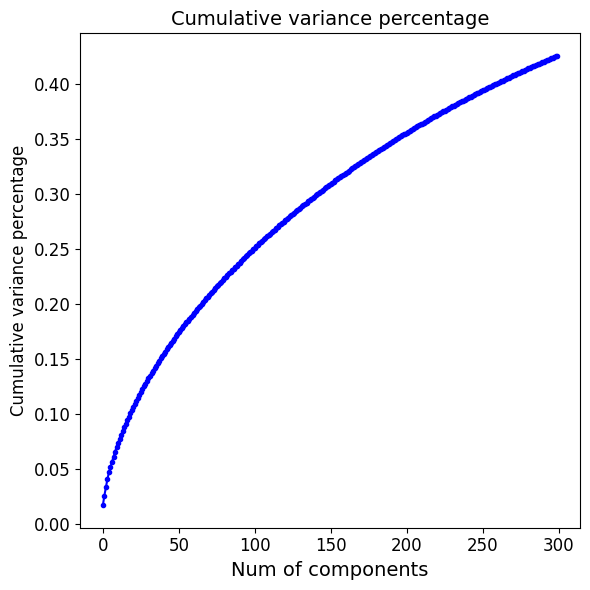

In [69]:
plot_cumulative_variance(estimator=svd)

In [70]:
title_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": ratings_pivot_merged_df["title"].str.to_lowercase(),
    }
)
latent_df: pl.DataFrame = pl.concat(
    [title_df, pl.DataFrame(latent_vectors)], how="horizontal"
)
latent_df.head(2)

title,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210,column_211,column_212,column_213,column_214,column_215,column_216,column_217,column_218,column_219,column_220,column_221,column_222,column_223,column_224,column_225,column_226,column_227,column_228,column_229,column_230,column_231,column_232,column_233,column_234,column_235,column_236,column_237,column_238,column_239,column_240,column_241,column_242,column_243,column_244,column_245,column_246,column_247,column_248,column_249,column_250,column_251,column_252,column_253,column_254,column_255,column_256,column_257,column_258,column_259,column_260,column_261,column_262,column_263,column_264,column_265,column_266,column_267,column_268,column_269,column_270,column_271,column_272,column_273,column_274,column_275,column_276,column_277,column_278,column_279,column_280,column_281,column_282,column_283,column_284,column_285,column_286,column_287,column_288,column_289,column_290,column_291,column_292,column_293,column_294,column_295,column_296,column_297,column_298,column_299
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,

In [71]:
movie_vector: np.ndarray = latent_df.filter(pl.col("title").eq(movie_title)).select(
    cs.float()
)

# Calculate the similarity of the product with the other ones.
cos_sim: np.ndarray = cosine_similarity(latent_df.select(cs.float()), movie_vector)
print(f"{cos_sim.shape = }")
similarity_measure_df: pl.DataFrame = pl.DataFrame(
    {"title": latent_df["title"], "similarity": cos_sim.flatten()}
).sort(by="similarity", descending=True)

# Reccommend movies to users based on their preferences
N: int = 10
columns: list[str] = ["title", "product_category"]
recommend_df: pl.DataFrame = (
    similarity_measure_df.join(products_df.select(columns), on="title", how="left")
    .slice(0, N)
    .select(columns + ["similarity"])
)
recommend_df

cos_sim.shape = (22262, 1)


title,product_category,similarity
str,str,f32
"""led zeppelin [vinyl]""","""classic rock | rock | hard rock & metal""",1.0
"""out of the cut""","""world | folk new age""",0.828647
"""2002""","""world new age | pop""",0.827399
"""fire wire""","""jazz | r&b | pop | blues""",0.730499
"""mejor de merengue""","""miscellaneous | pop | latin | world""",0.697686
"""love collection""","""pop | rock country""",0.697686
"""their greatest hits""","""world | folk""",0.697686
"""lexicon""","""pop | jazz""",0.651622
"""timelessness""","""jazz | pop | world""",0.651622


### Comment

- The similarity value is higher but it did NOT recommend too many movies with similar categories like `rock`.
- We'll try another dimensionality technique.

<br>

### Other Dimensionality Reduction Techniques

- LDA (Linear Discriminant Analysis [Supervised ML Technique])
- LDA (Latent Dirichlet Allocation)
- t-SNE (t-distributed Stochastic Neighbor Embedding)
- UMAP (Uniform Manifold Approximation and Projection)


<br>

### UMAP

In [72]:
import umap

n_components: int = 10
reducer: umap.UMAP = umap.UMAP(n_components=n_components)
latent_vectors: np.ndarray = reducer.fit_transform(
    ratings_pivot_merged_df.select(cs.float()).to_numpy()
)
latent_vectors.shape

2024-08-07 18:27:36.052829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(22262, 10)

In [73]:
title_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": ratings_pivot_merged_df["title"].str.to_lowercase(),
    }
)
latent_df: pl.DataFrame = pl.concat(
    [title_df, pl.DataFrame(latent_vectors)], how="horizontal"
)
movie_vector: np.ndarray = latent_df.filter(pl.col("title").eq(movie_title)).select(
    cs.float()
)

# Calculate the similarity of the product with the other ones.
cos_sim: np.ndarray = cosine_similarity(latent_df.select(cs.float()), movie_vector)
print(f"{cos_sim.shape = }")
similarity_measure_df: pl.DataFrame = pl.DataFrame(
    {"title": latent_df["title"], "similarity": cos_sim.flatten()}
).sort(by="similarity", descending=True)

# Reccommend movies to users based on their preferences
N: int = 10
columns: list[str] = ["title", "product_category"]
recommend_df: pl.DataFrame = (
    similarity_measure_df.join(products_df.select(columns), on="title", how="left")
    .slice(0, N)
    .select(columns + ["similarity"])
)
recommend_df

cos_sim.shape = (22262, 1)


title,product_category,similarity
str,str,f32
"""led zeppelin [vinyl]""","""classic rock | rock | hard rock & metal""",1.0
"""coda [vinyl]""","""classic rock | pop | rock | hard rock & metal""",0.999972
"""blonde on blonde (collector's edition)""","""classic rock | rock | pop | folk""",0.99978
"""the cry of love [vinyl]""","""r&b | hard rock & metal | rock | classic rock | pop""",0.999769
"""the new covenant""","""christian""",0.999759
"""burnin' (24bt) (mlps)""","""country | pop | blues | rock""",0.999759
"""burnin' [vinyl]""","""blues country | pop""",0.999757
"""on time""","""pop | rock | hard rock & metal | classic rock""",0.999757
"""i love rock n roll""","""rock | pop | classic rock | hard rock & metal""",0.999756
